# Plot BlueSeis BSPF Events from Catalog

! Should be run in pygmt environment !

With pressure sensor parascientific and new sensor 

In [1]:
import os 
import obspy as obs
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
# import geopandas as gpd

from andbro__savefig import __savefig
from obspy.clients.fdsn import Client

In [2]:
if os.uname().nodename == 'lighthouse':
    root_path = '/home/andbro/'
    data_path = '/home/andbro/kilauea-data/'
    archive_path = '/home/andbro/freenas/'
elif os.uname().nodename == 'kilauea':
    root_path = '/home/brotzer/'
    data_path = '/import/kilauea-data/'
    archive_path = '/import/freenas-ffb-01-data/'

## Configurations

In [91]:
config = {}

date1 = "20221001"
date2 = "20230615"


## small bounds
# config['minlatitude'], config['maxlatitude'] = 32, 35
# config['minlongitude'], config['maxlongitude'] = -118, -115
# config['eventfile'] = "BSPF_event_catalog"

## normal bounds
config['minlatitude'], config['maxlatitude'] = 31, 35
config['minlongitude'], config['maxlongitude'] = -119, -114
config['eventfile'] = f"BSPF_catalog_{date1}_{date2}"

## extended bounds
# config['minlatitude'], config['maxlatitude'] = 30, 37
# config['minlongitude'], config['maxlongitude'] = -120, -113
# config['eventfile'] = "BSPF_catalog_extended"


config['BSPF_lon'] = np.array([-116.455439])
config['BSPF_lat'] = np.array([33.610643])

config['minmagnitude'] = 2.5


config['tbeg'] = obs.UTCDateTime(date1)
config['tend'] = obs.UTCDateTime(date2)

config['triggerfile'] = f"BSPF_catalog_{date1}_{date2}_triggered.pkl"

config['gcmt_file'] = f"gcmt_solutions_{date1}_{date2}.xml"

config['path_to_data'] = data_path+"BSPF/data/"
config['path_trigger'] = data_path+"BSPF/data/catalogs/"
config['path_catalog'] = data_path+"BSPF/data/catalogs/"

config['out_figures'] = data_path+"BSPF/figures/"

config['outpath'] = data_path+"BSPF/"

In [45]:
from functions.catalog_to_dataframe import __catalog_to_dataframe
from functions.add_distances_and_backazimuth import __add_distances_and_backazimuth

In [46]:
def __read_pickle(path, filename):
    
    import pickle

    with open(path+filename, 'rb') as f:
        triggerfile = pickle.load(f)
        
    return triggerfile

In [47]:
def __find_matches(trigger_events, catalog):

    trigger_times, cosum = [], []
    for n, trig in enumerate(trigger_events.index):
        trigger_times.append(trig['trigger_time'][n])
        cosum.append(trig['coincidence_sum'])

    
    matches, time_diffs, events_triggered, idxs = [], [], [], []

    ## extract origin times from catalog
    event_times = [catalog.events[j].origins[0].time for j in range(len(catalog))]
    
    
    for trigger_time in trigger_times:

        ## compute time differences in seconds
        diff = [event_time-trigger_time for event_time in event_times]
        
        ## only the ones before the trigger in time
        abs_diff = [abs(d) for d in diff if d < 0]
        
        ## get closest event
        t_min, t_idx = min(abs_diff), diff.index(-min(abs_diff))
                
        time_diffs.append(t_min)
        matches.append(trigger_time)
        events_triggered.append(event_times[t_idx])
        idxs.append(t_idx)
        
    cat_sel = [catalog.events[idx] for idx in idxs]
        
        
    t_days = [(match-obs.UTCDateTime("2022-10-01"))/86400 for match in matches]
    plt.figure(figsize=(15,5))
    for tt, dd, cosum in zip(t_days, time_diffs, cosum):
        if cosum == 4:
            plt.scatter(tt, dd, zorder=2, color='red', s=13, alpha=0.7)
        if cosum == 5:
            plt.scatter(tt, dd, zorder=2, color='orange', s=13, alpha=0.7)
        if cosum == 6:
            plt.scatter(tt, dd, zorder=2, color='green', s=13, alpha=0.7)
            
    plt.yscale("log")
    plt.grid(which="both", zorder=-1, ls=":")
    plt.ylabel("Time Differences (s)")
    plt.xlabel("Time (days)")
    plt.xlim(0, 190)
    plt.title(f"LTA-STA Trigger: {len(events_triggered)}")
    
    return np.array(matches), np.array(events_triggered), cat_sel

In [48]:
!ls /home/andbro/kilauea-data/BSPF/data/catalogs/

ls: cannot access '/home/andbro/kilauea-data/BSPF/data/catalogs/': No such file or directory


## Load Data

### load catalog with all events

In [49]:
cat_all = obs.read_events(config['path_catalog']+config['eventfile']+"_all.xml")

events_all_df = __catalog_to_dataframe(cat_all)

events_all_df = __add_distances_and_backazimuth(config['BSPF_lat'], config['BSPF_lon'], events_all_df)

In [50]:
events_all_df = events_all_df.rename_axis('timestamp').reset_index()
events_all_df['seconds'] = [abs((events_all_df.timestamp.min()-tt).total_seconds()) for tt in events_all_df.timestamp]

### load triggered events

In [51]:
trigger_events = __read_pickle(config['path_trigger'], config['triggerfile'])

In [52]:
cat_select_df = trigger_events

In [53]:
# trigger_times, cosum = [], []
# for n, trig in enumerate(trigger_events):
#     print(trig)
# #     trigger_times.append(trig['trigger_time'][n])
#     print(trig["trigger_time"][n])
# #     cosum.append(trig['coincidence_sum'])

In [54]:
# matches, events_triggered, cat_select = __find_matches(trigger_events, cat_all)

In [55]:
# cat_select_df = __cat_to_df(cat_select)

# cat_select_df = __add_distances_and_backazimuth(config, cat_select_df)

cat_select_df = cat_select_df.rename_axis('timestamp').reset_index()
cat_select_df['seconds'] = [abs((cat_select_df.timestamp.min()-tt).total_seconds()) for tt in cat_select_df.timestamp]

In [56]:
cat_select_df

,timestamp,latitude,longitude,depth,magnitude,type,seconds,trigger_time,cosum,backazimuth,distances_km
0,2022-10-02 03:25:16.440,33.484333,-116.508500,8040.0,1.49,ml,0.00,2022-10-02T03:25:19.344538Z,4.0,19.364710,14.850966
1,2022-10-03 16:08:09.970,33.924667,-116.921500,7620.0,3.01,ml,132173.53,2022-10-03T16:08:19.219538Z,6.0,128.765512,55.472148
2,2022-10-03 16:08:09.970,33.924667,-116.921500,7620.0,3.01,ml,132173.53,2022-10-03T16:08:19.219538Z,6.0,128.765512,55.472148
3,2022-10-05 15:39:13.690,33.494500,-116.509500,12410.0,0.50,ml,303237.25,2022-10-05T15:39:17.944539Z,4.0,21.277323,13.825658
4,2022-10-07 22:45:05.470,33.041333,-116.354667,11790.0,3.47,mlr,501589.03,2022-10-07T22:45:15.894539Z,6.0,351.575554,63.835594
...,...,...,...,...,...,...,...,...,...,...,...
95,2023-05-24 19:11:52.210,33.952667,-116.645333,11420.0,2.22,ml,20274395.77,2023-05-24T19:11:59.335000Z,4.0,155.073931,41.815491
96,2023-05-31 23:27:27.570,33.950667,-116.642833,16340.0,2.35,ml,20894531.13,2023-05-31T23:27:34.805000Z,4.0,155.235515,41.517082
97,2023-06-04 04:43:02.890,33.140667,-116.526500,7720.0,3.16,ml,21172666.45,2023-06-04T04:43:11.320000Z,5.0,7.210330,52.543371
98,2023-06-07 06:03:42.030,33.965667,-116.946000,7240.0,2.58,ml,21436705.59,2023-06-07T06:03:52.075000Z,4.0,130.780515,60.123060


### load GCMT catalog

In [57]:
cat_gcmt = obs.read_events(config['path_catalog']+config['gcmt_file'])

In [58]:
cat_gcmt_df = __catalog_to_dataframe(cat_gcmt)
cat_gcmt_df.magnitude.min(), cat_gcmt_df.shape

(5.1, (319, 5))

In [59]:
focal_mechanism = dict(
                        strike=[330, 300],
                        dip=[30, 20],
                        rake=[90, 80],
                        magnitude=[3.0, 3.5],
)

### load shape file for faults

from USGS: https://usgs.maps.arcgis.com/apps/webappviewer/index.html?id=5a6038b3a1684561a9b0aadf88412fcf

In [60]:
# faults = gpd.read_file(config['path_to_data']+"hazfaults2014/hazfaults2014.shp")

In [61]:
# x,y = faults.geometry[0].coords.xy
# print(np.array(x))
# plt.plot(x,y)

## Plot Triggered Catalog

### Plots

In [103]:
def __plot_timeline(catalog_df, catalog_all_df):

    fig, ax = plt.subplots(1, 1, figsize=(15,5))

    catalog_all_df.sort_values("magnitude")
    catalog_df.sort_values("magnitude")
    
    
    cax = ax.scatter(catalog_df.timestamp, 
                     catalog_df.distances_km, 
                     s=4**catalog_df.magnitude, 
                     c=catalog_df.magnitude, 
                     alpha=1.0, 
                     cmap='viridis',
                     marker='o', facecolors='none', edgecolors='r'
                    )

    ax.scatter(catalog_all_df.timestamp, catalog_all_df.distances_km, s=4**catalog_all_df.magnitude, c='grey', alpha=0.5, zorder=-1)

    
    cbar = plt.colorbar(cax, ax=ax, cmap='viridis', pad=0.01, aspect=15, drawedges=False)
    cbar.set_label(label='Magnitude', size=16, color="white", labelpad=-40)
    
    
    ax.set_ylim(bottom=0)
    ax.set_ylabel("Distance (km)", fontsize=14)

    ax.grid(ls=":", zorder=-1)
    
#     ax.set_xlim(events_all_df.timestamp.min().date(), events_all_df.timestamp.max().date())
    ax.set_xlim(str(config['tbeg']-4*86400), str(config['tend']+4*86400))

    ax.set_title(f"triggered={len(catalog_df)} of {len(catalog_all_df)} events", fontsize=18)
    
#     ax.tick_params(axis="y", labelsize=15)
#     ax.tick_params(axis="x", labelsize=15)    
    
    plt.show();
    return fig

In [104]:
events_all_df[events_all_df.magnitude > 4.1]

,timestamp,latitude,longitude,depth,magnitude,type,backazimuth,distances_km,seconds
1506,2023-04-30 07:58:19.380,33.203667,-115.585833,1890.0,4.26,mw,299.400741,92.633226,18258584.95
1530,2023-04-30 07:10:10.180,33.189333,-115.593333,1880.0,4.29,mw,300.463441,92.820385,18255695.75
1531,2023-04-30 07:09:34.500,33.200833,-115.590000,2040.0,4.33,mw,299.686308,92.450188,18255660.07
2577,2023-04-01 01:16:07.810,33.381667,-116.909667,12960.0,4.15,mw,58.840633,49.261011,15728853.38
4475,2023-01-25 10:00:54.680,33.885000,-118.704500,14710.0,4.19,mw,97.682270,210.596640,10057940.25
5110,2022-12-31 12:12:26.650,33.397500,-116.393333,3880.0,4.14,mw,346.299211,24.334570,7905832.22


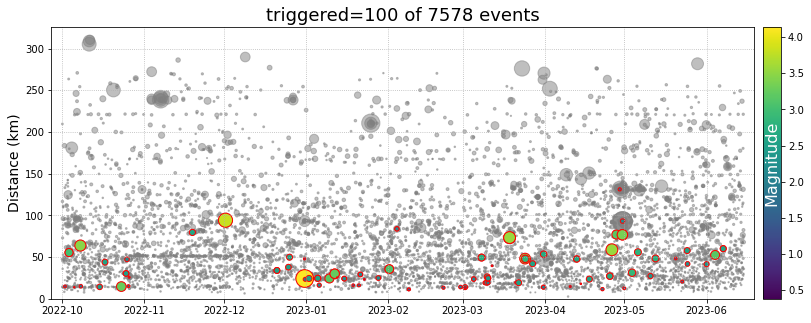

In [105]:
fig = __plot_timeline(cat_select_df, events_all_df)

fig.savefig(config['out_figures']+"timeline_triggered_extended.png")

In [107]:
__savefig(fig, config['out_figures'], "BSPF_timeline_trigger", mode="png", dpi=200)


   -> saving /import/kilauea-data/BSPF/figures/BSPF_timeline_trigger.png ...

   -> Done



In [25]:
# for lon, lat, st, dp, rk, mg in zip(lons, lats, strikes, dips, rakes, magnitudes):
#     with pygmt.helpers.GMTTempFile() as temp_file: 
#         with open(temp_file.name, 'w') as f:
#             f.write(f'{lon} {lat} 0 {st} {dp} {rk} {mg} 0 0') #moment tensor: lon, lat, depth, strike, dip, rake, magnitude
#         with pygmt.clib.Session() as session:
#             session.call_module('meca', f'{temp_file.name} -Sa0.2i')

### Map Plot

In [30]:
def __makeplot_eventmap(config, data1, data2):
    

    import pygmt
    import pandas as pd
    from obspy.imaging.beachball import beach
    
    # Set the region
    region = [config['minlongitude'], config['maxlongitude'], config['minlatitude'], config['maxlatitude']]

    resolution = "30s"

    fig = pygmt.Figure()
    
#     fig.basemap(region=region, projection="M15c", frame=True)


    # make color pallets
    cmap = pygmt.makecpt(cmap='etopo1', series='-7999/5000/1000', continuous=True)
    
    ## define etopo data file
    topo_data = pygmt.datasets.load_earth_relief(resolution=resolution, region=region)
    
    ## adjust land and sea/lakes
#     land = topo_data * pygmt.grdlandmask(region=region, 
#                                          spacing=resolution, 
#                                          maskvalues=[0, 1], 
#                                          resolution="f"
#                                         )
    wet = topo_data * pygmt.grdlandmask(region=region, 
                                        spacing=resolution, 
                                        maskvalues=[1, "NaN"], 
                                        resolution="f"
                                       )
    
    ##plot high res topography
    fig.grdimage(
        grid=topo_data,
        region=region,
        projection='M5i',
        shading=True,
        cmap = cmap,
        frame=True,
        nan_transparent=True
    )     


#     cmap_wet = pygmt.makecpt(cmap='etopo1', series='-7999/5000/1000', continuous=True)

    fig.grdimage(
        grid=wet,
        region=region,
        projection='M5i',
        shading=True,
        cmap='seafloor',
        frame=True,
        nan_transparent=True
    )
    
    
    cmap = pygmt.makecpt(cmap='etopo1', series='-8000/5000/1000', continuous=True)    
    fig.colorbar(cmap=cmap, position="g-118.8/31.45+w3c/0.3c+h", box="+gwhite+c0.1+r", 
                 frame=["x+lElevation", r"y+l(km)"], scale=0.001, transparency=20)    


    ## add coastlines
    fig.coast(shorelines=True, borders="1/0.4p,black,solid", frame=False)

    ## add map scale
    fig.basemap(map_scale="jBL+c32+f+w50k+u+o10.9/.6",frame=False)
    
    ## add north rose
#     fig.basemap(rose='jTR+o0.1c+w1c',frame=False)
    
        
    ## add fault lines
#     faults.plot()
#     for n in range(faults.shape[0]):
#         try:
#             xx, yy = faults.geometry[n].coords.xy
#             fig.plot(x=xx,y=yy,pen="1p,red")
#         except:
#             print(n)    
    
    ## colorbar colormap
#     cmap_mag = pygmt.makecpt(cmap="viridis", series=[data1.magnitude.min(), data1.magnitude.max()])
#     cmap_mag = pygmt.makecpt(cmap="viridis", series=[data1.timestamp.astype(str)[0], data1.timestamp.astype(str)[len(data1)-1]])
#     cmap_mag = pygmt.makecpt(cmap="viridis", series=[data1.seconds.min(), data1.seconds.max()])
    cmap_depth = pygmt.makecpt(cmap="viridis", series=[data1.depth.min()/1000, data1.depth.max()/1000])
    
#     ## plot data coordinates
    fig.plot(
        x=data2.longitude,
        y=data2.latitude,
        size=0.04*2**data2.magnitude,
        fill='grey',
        style="cc",
        pen="0p,black",
    )    

    fig.plot(
        x=data1.longitude,
        y=data1.latitude,
        size=0.04*2**data1.magnitude,
        fill=data1.depth/1000,
#         fill=data1.seconds,
        cmap=True,
        style="cc",
        pen="0.1p,black",
        transparency=50,        
    )    

    ## plot PFO
    fig.plot(
        x=config['BSPF_lon'],
        y=config['BSPF_lat'],
        size=np.array([0.3]),
        fill="red",
        style="t0.5c",
        pen="black",
    )
    
    fig.text(
        text="PFO",
        x=config['BSPF_lon'],
        y=config['BSPF_lat'],
        offset=[0.35],
        font="9p,Helvetica-Bold,black"
    )
    
    ## add beachball
#     fig.meca(
#         spec=focal_mechanism, ## use dictionary
#         scale="1c", 
#         longitude=[-118.3, -120], ## event longitude
#         latitude=[33.1, 34.5], ## event latitude
#         depth=[12.0, 10.0], ## hypocentral depth
#     )
    
    
#     fig.plot(
#         x=config['BSPF_lon'],
#         y=config['BSPF_lat'],
#         size=10,
#         style="cc",
#         pen="0.1p,red",
#         transparency=100,        
#     )    
    
    ## add depth colorbar
#     fig.colorbar(frame='af+l"Depth (km)"', cmap=cmap_depth)
#     fig.colorbar(frame='af+l"Days"', transparency=20, cmap=cmap_mag, 
#                  position="JMR+o-2.2c/3.1c+w5c/0.5c+n+mc", scale=1/86400, 
#                  box="+gwhite+c0.1+r")
    fig.colorbar(frame='af+l"Depth (km)"', transparency=20, cmap=cmap_depth, 
                 position="JMR+o-2.2c/3.1c+w5c/0.5c+n+mc", 
                 box="+gwhite+c0.1+r")
    
    ## save figure to file
    fig.savefig(config['outpath']+'tmp_event_map.png')

    fig.show();
    return fig

In [31]:
fig = __makeplot_eventmap(config, cat_select_df, events_all_df)

pygmt-session [WARNING]: Remote dataset given to a data processing module but no registration was specified - default to gridline registration (if available)
plot [ERROR]: Malformed -f argument [illgrey]
plot [ERROR]: Option -f parsing failure. Correct syntax:

-f[i|o]<colinfo>
Indicate content of input/output columns. Optionally append i(nput) or o(utput)
     [Default is both]. Append <colinfo> as one or more comma-separated groups of
     <cols><type>, where <cols> is a column (or column ranges) and <type> is the column
     type, chosen from T (Calendar format), t (time relative to TIME_EPOCH), f (floating
     point), x (longitude), y (latitude), or d (dimension). You may also use s (string)
     to indicate the start column of trailing text. Shortcuts: -f[i|o]g means -f[i|o]0x,⏎
     …1y (geographic, i.e., lon/lat coordinates), -f[i|o]c means -f[i|o]0:1f (Cartesian
     coordinates), while -fp[<unit>] means input x,y are already in projected coordinates
     in <unit> [e].
plot [

GMTCLibError: Module 'plot' failed with status code 72:
plot [ERROR]: Malformed -f argument [illgrey]
plot [ERROR]: Option -f parsing failure. Correct syntax:
plot [ERROR]: Offending option -fillgrey

In [32]:
fig.savefig(config['out_figures']+"map_triggered.png")

## Centered Plot

In [ ]:
# client = Client("ISC")

# ## events - all in area and time period
# events_all = client.get_events(minlatitude=config['minlatitude'], maxlatitude=config['maxlatitude'],
#                                minlongitude=config['minlongitude'], maxlongitude=config['maxlongitude'],
#                                starttime=config['tbeg'],
#                                endtime=config['tend'],
#                                )

In [ ]:
# origin = event.preferred_origin() or event.origins[0]
# focmec = event.preferred_focal_mechanism() or event.focal_mechanisms[0]
# tensor = focmec.moment_tensor.tensor
# moment_list = [tensor.m_rr, tensor.m_tt, tensor.m_pp,
#                tensor.m_rt, tensor.m_rp, tensor.m_tp]

In [33]:
def __makeplot_polarmap(config, data1, data2):

    import pygmt

    reg = [config['minlongitude'], config['maxlongitude'], config['minlatitude'], config['maxlatitude']]

    scale = "8c"

    proj = f"E{config['BSPF_lon'][0]}/{config['BSPF_lat'][0]}/1/{scale}"

    resolution = "30s"

    ## __________________________________________

    fig = pygmt.Figure()

    fig.coast(projection=proj, region=reg, land="gray")


    fig.basemap(
        region=[0, 360, 0, 10],
        projection=f"P{scale}+a",
        frame=["xa45f", "+t"],
    )
    

    # make color pallets
    cmap = pygmt.makecpt(cmap='etopo1', series='-7999/5000/1000', continuous=True)

    ## define etopo data file
    topo_data = pygmt.datasets.load_earth_relief(resolution=resolution, region=reg)



    ##plot high res topography
    fig.grdimage(
        grid=topo_data,
        region=reg,
        projection=proj,
        shading=True,
        cmap = cmap,
        frame=True,
        nan_transparent=True
    )     

    wet = topo_data * pygmt.grdlandmask(region=reg,  spacing=resolution, maskvalues=[1, "NaN"], resolution="f")

    fig.grdimage(
        grid=wet,
        region=reg,
        projection=proj,
        shading=True,
        cmap='seafloor',
        frame=True,
        nan_transparent=True
    )

    fig.coast(shorelines=True, borders="1/0.4p,black,solid", frame=False)

    ## colorbar colormap
    cmap_mag = pygmt.makecpt(cmap="viridis", series=[data1.magnitude.min(), data1.magnitude.max()])
    #     cmap_mag = pygmt.makecpt(cmap="viridis", series=[data1.timestamp.astype(str)[0], data1.timestamp.astype(str)[len(data1)-1]])
    cmap_mag = pygmt.makecpt(cmap="viridis", series=[data1.seconds.min(), data1.seconds.max()])


    ## plot data coordinates
    fig.plot(
        x=data2.longitude,
        y=data2.latitude,
        size=0.04*2**data2.magnitude,
        fill='grey',
        style="cc",
        pen="0p,black",
    )    

    fig.plot(
        x=data1.longitude,
        y=data1.latitude,
        size=0.04
        *2**data1.magnitude,
        fill=data1.seconds,
        cmap=True,
        style="cc",
        pen="0.1p,black",
        transparency=50,        
    )    

    ## plot PFO
    fig.plot(
        region=reg, projection=proj,
        x=config['BSPF_lon'],
        y=config['BSPF_lat'],
        size=np.array([0.3]),
        fill="red",
        style="t0.5c",
        pen="black",
    )

    fig.text(
        region=reg, projection=proj,
        text="PFO",
        x=config['BSPF_lon'],
        y=config['BSPF_lat'],
        offset=[0.35],
        font="9p,Helvetica-Bold,black"
    )

    fig.show()
    return fig

In [34]:
fig = __makeplot_polarmap(config, cat_select_df, events_all_df)

coast [WARNING]: Fill/clip continent option (-G) may not work for this projection.
coast [WARNING]: If the antipode (-0/0) is in the ocean then chances are good it will work.
coast [WARNING]: Otherwise, avoid projection center coordinates that are exact multiples of 63.5446 degrees.
pygmt-session [WARNING]: Remote dataset given to a data processing module but no registration was specified - default to gridline registration (if available)
plot [ERROR]: Malformed -f argument [illgrey]
plot [ERROR]: Option -f parsing failure. Correct syntax:

-f[i|o]<colinfo>
Indicate content of input/output columns. Optionally append i(nput) or o(utput)
     [Default is both]. Append <colinfo> as one or more comma-separated groups of
     <cols><type>, where <cols> is a column (or column ranges) and <type> is the column
     type, chosen from T (Calendar format), t (time relative to TIME_EPOCH), f (floating
     point), x (longitude), y (latitude), or d (dimension). You may also use s (string)
     to in

GMTCLibError: Module 'plot' failed with status code 72:
plot [ERROR]: Malformed -f argument [illgrey]
plot [ERROR]: Option -f parsing failure. Correct syntax:
plot [ERROR]: Offending option -fillgrey

In [ ]:
fig.savefig(config['out_figures']+f'BSPF_polarmap.png', dpi=200, bbox_inches='tight', pad_inches=0.05)

## Plot Histogram

In [ ]:
def __makeplot_histogram(catalog_all_df, catalog_df):
    
    from sklearn.linear_model import LinearRegression
    from numpy import log10, array, linspace


    catalog_all_df = catalog_all_df.sort_values("magnitude", ascending=False)
    catalog_df = catalog_df.sort_values("magnitude")    
    
    ## bins=11, range=[-0.75,4.75]
#     hh_cum, bins_cum, _ = plt.hist(catalog_all_df.magnitude, bins=11, range=[-0.75,4.75], rwidth=0.9, color='#3776ab', cumulative=True)    
#     plt.close()    
#     bins_cum = [bins_cum[jj] + (abs(bins_cum[jj+1]-bins_cum[jj])/2) for jj in range(len(bins_cum)-1)]

    ## compute bins catalog all
    nn, bins = [], []
    for i in range(-1, 7, 1):
        nn.append(len(catalog_all_df[catalog_all_df.magnitude >= i]))
        bins.append(i+0.5)

    print(len(catalog_df), len(catalog_df[catalog_df.magnitude >= 4]))
    ## compute bins catalog triggered
    nn2, bins2 = [], []
    for i in range(-1, 7, 1):
        nn2.append(len(catalog_df[catalog_df.magnitude >= i]))
        bins2.append(i+0.5)
        
        
    x, y = array(bins)[2:-1], log10(nn[2:-1])

    ## ________________________________
    
    fig, ax = plt.subplots(1, 1, figsize=(5,5))
    
    ## plot histograms catalog all
    ax.bar(array(bins), nn, width=0.75, color='lightblue', zorder=2, alpha=0.8)
    ax.bar(x, 10**y, width=0.75, zorder=2)
    
    ## plot histograms catalog triggered
    ax.bar(array(bins2), nn2, width=0.5, color='darkorange', zorder=2, alpha=0.5)
#     ax.bar(x2, 10**y2, width=0.75, zorder=2)
         
        
        
    ## linear regression
    model = LinearRegression().fit(x.reshape((-1, 1)), y)
    r_sq = model.score(x.reshape((-1, 1)), y)
    x_axis = linspace(min(bins), max(bins), 50)
    reg1 = model.intercept_ + model.coef_ * x_axis
    
    ax.plot(x_axis, 10**reg1, color="k", ls="--", label=f"f(x)={round(model.coef_[0],2)}x+{round(model.intercept_,1)}")

    ## linear regression
    x2, y2 = x[:-1], y[:-1]
    model = LinearRegression().fit(x2.reshape((-1, 1)), y2)
    r_sq = model.score(x2.reshape((-1, 1)), y2)
    x_axis = linspace(min(bins), max(bins), 50)
    reg2 = model.intercept_ + model.coef_ * x_axis
    
#     ax.plot(x_axis, 10**reg2, color="k", ls=":", label=f"f(x)={round(model.coef_[0],2)}x+{round(model.intercept_,1)}")
    
    
    ax.text(3.5, 9e3, f"Total N = {len(catalog_all_df)}", fontsize=13)
    
    days = str(events_all_df.index.max()-events_all_df.index.min()).split(" ")[0]
    ax.text(3.5, 4e3, f"Days = {days}", fontsize=13)
    
    ax.grid(zorder=-1, ls=":", alpha=0.7, which="both")
    
    ax.legend(loc="upper right", fontsize=12)
    
    ax.set_yscale("log")
    
    ax.set_xlabel("Magnitude", fontsize=18)
    ax.set_ylabel("Number of Events", fontsize=18)
    
    ax.tick_params(axis='x', labelsize=11)
    ax.tick_params(axis='y', labelsize=11)
    
    ax.set_xticks(array(bins)-0.5)
    
    ax.set_title(f"Gutenberg-Richter Relation", fontsize=18)
    
    ax.tick_params(axis="y", labelsize=15)
    ax.tick_params(axis="x", labelsize=15)
    
    ax.set_ylim(0.2e0, 1e5)
    plt.show();
    return fig

In [ ]:
fig = __makeplot_histogram(events_all_df, cat_select_df)

fig.savefig("catalog_all_histo.png")